# Introduction

This notebook presents **Convolutional Neural Network** applied to [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

**Contents**

* [CIFAR-10 Dataset](#CIFAR-10-Dataset) - load and preprocess dataset
* [Keras Model](#Keras-Model) - make and train model

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import pdb

In [2]:
from torchsummary import summary
import torchviz
#import tensorboardX

Pick GPU if available

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
x1 = torch.tensor([0., 1, 2, 3], requires_grad=True)
x2 = torch.tensor([2., 3, 4, 5], requires_grad=True)

h1 = x1 * x2
h2 = h1**2
y_hat = torch.sum(h2)

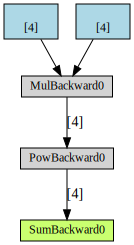

In [18]:
hooks = add_hooks(y_hat)
y_hat.backward()
make_dot(y_hat, inputs={'x1':x1, 'x2':x2}, params=None, hooks=hooks)

In [4]:
class GradFnHook():
    def __init__(self, grad_fn):
        self.iter = 0
        self.grad_fn = grad_fn
    def __call__(self, inputs, outputs):
        self.iter += 1
        self.inputs = inputs
        self.outputs = outputs

In [5]:
def add_hooks(output_tensors):
    
    def add_nodes(var):
        if var not in seen:
            
            bh = GradFnHook(var)
            var.register_hook(bh)
            
            hooks[var] = bh
            seen.add(var)
            
            #if hasattr(var, 'next_functions'):
            for u in var.next_functions:
                if u[0] is not None:
                    add_nodes(u[0])

    # convert to tuple
    if not isinstance(output_tensors, tuple):
        nodes = (output_tensors.grad_fn,)
    else:
        nodes = tuple(ot.grad_fn for ot in output_tensors)
    
    hooks = {}
    seen = set()
    
    for grad_fn in nodes:
        add_nodes(grad_fn)
        
    return hooks

# Graph Visualization

Functions in this section are copy-pasted from [https://github.com/szagoruyko/pytorchviz](https://github.com/szagoruyko/pytorchviz)

In [6]:
from graphviz import Digraph

In [7]:
# Copied from https://github.com/szagoruyko/pytorchviz
def resize_graph(dot, size_per_element=0.15, min_size=12):
    """Resize the graph according to how much content it contains.
    Modify the graph in place.
    """
    # Get the approximate number of nodes and edges
    num_rows = len(dot.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    dot.graph_attr.update(size=size_str)
    
def size_to_str(size):
    return '[' + (', ').join(['%d' % v for v in size]) + ']'

In [8]:
def rchop(string, endings):
    for ending in endings:
        if string.endswith(ending):
            return string[:-len(ending)]
    return string

In [9]:
def var_to_str(var):
    return rchop(type(var).__name__, ['Backward', 'Backward1'])

In [14]:
# Copied from https://github.com/szagoruyko/pytorchviz
def make_dot(var, inputs=None, params=None, hooks=None):
    """ Produces Graphviz representation of PyTorch autograd graph.
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {}
    if params is not None:
        assert all(isinstance(p, torch.Tensor) for p in params.values())
        for k, v in params.items():
            param_map[id(v)] = k
    if inputs is not None:
        assert all(isinstance(i, torch.Tensor) for i in inputs.values())
        for k, v in inputs.items():
            param_map[id(v)] = k
        

    node_attr = dict(style='filled', shape='box', align='left', fontsize='12', ranksep='0.1', height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()



    output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)
    
    assert isinstance(output_nodes, tuple)

    def add_nodes(var):
        if var not in seen:
            if hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            elif var in output_nodes:
                dot.node(str(id(var)), var_to_str(var), fillcolor='darkolivegreen1')
            else:
                dot.node(str(id(var)), var_to_str(var))
            
            seen.add(var)
            
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        
                        if hooks is not None and not hasattr(u[0], 'variable'):
                            inp_tup = hooks[var].inputs  # tensor
                            out_tup = hooks[u[0]].outputs
                            inters = set(inp_tup).intersection(set(out_tup))
                            assert len(inters) == 1
                            tensor = inters.pop()
                            label = size_to_str(tensor.size())
                        else:
                            label = None
                        
                        dot.edge(str(id(u[0])), str(id(var)), label=label)
                        add_nodes(u[0])
            
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    
                    pdb.set_trace()
                    
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
                    
        
    for grad_fn in output_nodes:
        add_nodes(grad_fn)

    resize_graph(dot)

    return dot

# PyTorch Model

In [8]:
# writer = tensorboardX.SummaryWriter()
# x = torch.randn(10, 3, 32, 32, device=device)             # construct mini-batch
# writer.add_graph(model, input_to_model=x)

In [26]:
from collections import OrderedDict
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.elu1 = nn.ELU()
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.layer1 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)),
            ('elu', nn.ELU()),
            ('pool', nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        ]))
        
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.lin1 = nn.Linear(in_features=1024, out_features=512)
        self.lin2 = nn.Linear(in_features=512, out_features=10)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
#         x = self.elu1(x)
#         x = self.conv1(x)
#         x = self.maxpool1(x)
        
        x = self.layer1(x)
        
        x = self.maxpool(F.elu(self.conv2(x)))
        x = self.maxpool(F.elu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = F.elu(self.lin1(x))
        x = self.drop(x)
        x = self.lin2(x)  # no activation after last linear
        return x

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()                 # softmax included in here
optimizer = torch.optim.Adam(model.parameters())

In [27]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
               ELU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
         MaxPool2d-5             [-1, 32, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]          18,496
         MaxPool2d-7             [-1, 64, 4, 4]               0
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
          Dropout-10                  [-1, 512]               0
           Linear-11                   [-1, 10]           5,130
Total params: 553,514
Trainable params: 553,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
def hook(module, input, output):
    class_name = str(module.__class__).split(".")[-1].split("'")[0]
    print('NAME:', module_to_string[module], class_name)
    print('  inputs: ', end='')
    for inp in input:
        print(list(inp.shape), end=' ')
    print()
    #pdb.set_trace()
    pass

In [ ]:
def register_hook(module):
    if (not isinstance(module, nn.Sequential)
        and not isinstance(module, nn.ModuleList)
        and not (module == model)):
        hooks.append(module.register_forward_hook(hook))

In [ ]:
for h in hooks:
    h.remove()
hooks = []
model.apply(register_hook)

In [99]:
x = torch.randn(10, 3, 32, 32, device=device, requires_grad=True);  #x.requires_grad = True
params = dict(model.named_parameters()); #params['x'] = x
o = model(x)

In [100]:
hooks = add_hooks(o)

In [101]:
o.backward(torch.ones_like(o))

In [102]:
make_dot(o, inputs={'x': x}, params=params, hooks=hooks)

RuntimeError: The size of tensor a (10) must match the size of tensor b (32) at non-singleton dimension 3

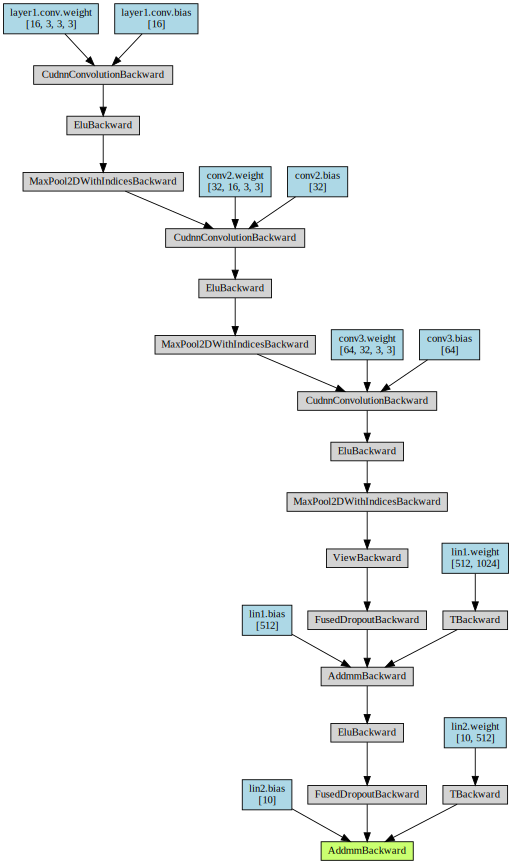

In [76]:
#print(model)
#summary(model, input_size=(3, 32, 32))

x = torch.randn(10, 3, 32, 32, device=device);  #x.requires_grad = True
params = dict(model.named_parameters()); #params['x'] = x
make_dot(model(x), params=params)

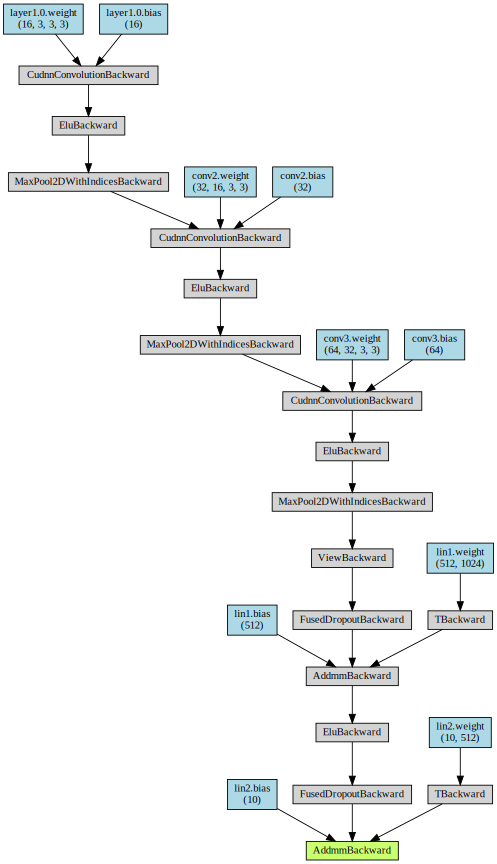

In [33]:
import torchviz
torchviz.make_dot(model(x), params=params)

# U-Net

In [4]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dconv_down2 = double_conv(64, 128)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dconv_down3 = double_conv(128, 256)
        self.maxpool3 = nn.MaxPool2d(2)
        self.dconv_down4 = double_conv(256, 512)        
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool1(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool2(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool3(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return x # out

unet = UNet(n_class=6)
unet.to(device);

In [5]:
# import tensorboardX

In [6]:
# writer = tensorboardX.SummaryWriter()
# x = torch.randn(10, 3, 32, 32, device=device)             # construct mini-batch
# writer.add_graph(model, input_to_model=x)

In [ ]:
x = torch.randn(10, 3, 192, 192, device=device)
writer.add_graph(unet, input_to_model=x)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconv_down4): Sequential(
    (

/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


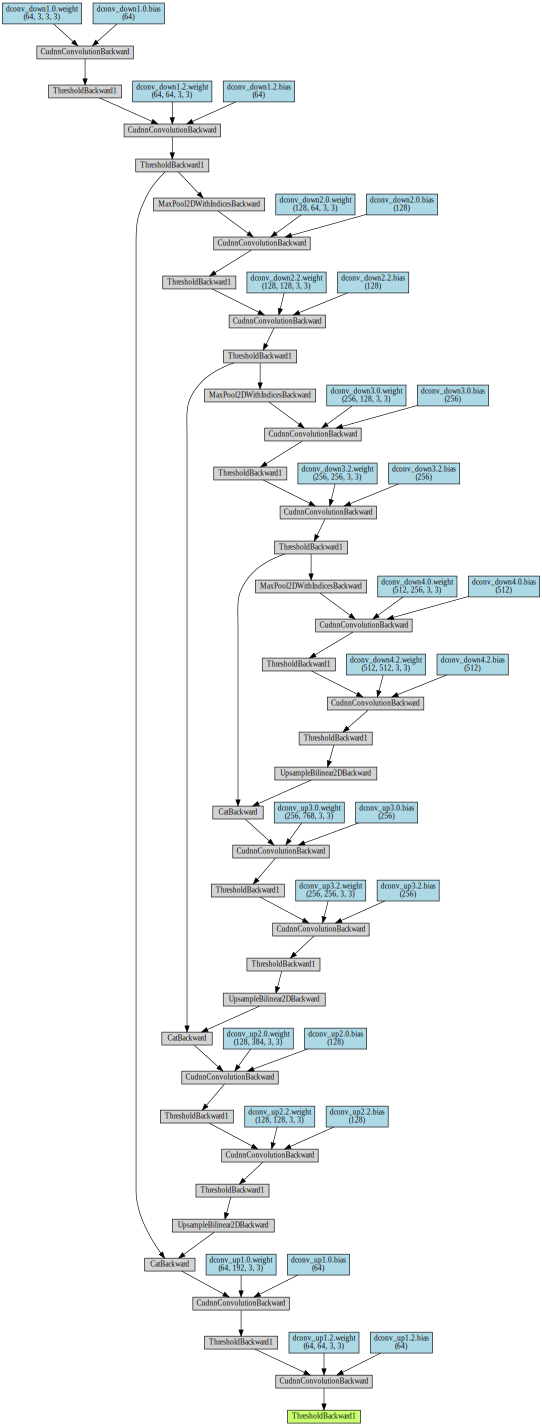

In [5]:
print(unet)
summary(unet, input_size=(3, 192, 192))

x = torch.randn(10, 3, 192, 192, device=device)
#x.requires_grad = True                              # mark requires_grad, otherwise 'x' won't show on the graph
outputs = unet(x)                                  # do forward pass - graph gets constructed

params = dict(unet.named_parameters())
#params['x'] = x

torchviz.make_dot(outputs, params=params)

In [6]:
torch.save(unet, 'unet.pth')

/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
